In [1]:
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-bright')
import numpy as np
from PIL import Image
import glob
import moviepy.editor as mp
from datetime import datetime
import time

In [2]:
class Mol():
    def __init__(self, r, rv, ra):
        self.r = np.asarray([0.0, 0.0]) 
        self.rv = np.asarray([0.0, 0.0])
        self.ra = np.asarray([0.0, 0.0])
        
        
class Prop():
    def __init__(self, val, sum1, sum2 ):
        self.val=val
        self.sum1=sum1
        self.sum2=sum2     

In [3]:
# BASIC FUNCTIONS

# Sqr and Cube functions:

def Sqr(x):
    return (x * x) 

def Cube(x):
    return ((x) * (x) * (x))

  
# Randomness functions: 

def RandR():
    global randSeedP
    randSeedP = (randSeedP * IMUL + IADD) & MASK
    return (randSeedP * SCALE)

def VRand(p):
    s: float
    s = 2. * math.pi * RandR()
    p[0] = math.cos(s)
    p[1] = math.sin(s)
    return p


# Toroidal functions:
def VWrapAll(v):
    if v[0] >= 0.5 * region[0]:
        v[0] -= region[0]
    elif v[0] < -0.5 * region[0]:
        v[0] += region[0]
        
    if v[1] >= 0.5 * region[1]:
        v[1] -= region[1]
    elif v[1] < -0.5 * region[1]:
        v[1] += region[1]        
        
    
# This function updates coordinates taking care of periodic boundaries    
def ApplyBoundaryCond():
    for n in range(nMol):
        VWrapAll(mol[n].r)


In [4]:
# INITIALIZE COORDINATES.
# Here a simple square lattice (with the option of unequal edge lenghts) is used,
# so that each cell contains just one atom and the system is centered about the origin
def InitCoords():

    c = np.asarray([0.0, 0.0]) # Coords
    gap = np.divide(region, initUcell)
    n = 0
    for ny in range(0, int(initUcell[1])):
        for nx in range(0, int(initUcell[0])):
            
            #c = np.asarray([nx+0.5, ny+0.5])
            #c = np.multiply(c, gap)
            #c = np.add(c, np.multiply(-0.5, region))
            #mol[n].r = c   
            
            mol[n].r = np.add(np.multiply(np.asarray([nx+0.5, ny+0.5]), gap), np.multiply(-0.5, region)) 
            n = n+1
            
            
# INITIALIZE VELOCITIES.
# The initial velocities are set to fixed magnitude (velMag)
# that depends on the temperature. After assigning random velocity directions
# the velocoties are adjusted to ensure that the center of mass is stationary.
# The function vRand serves as a source of uniformly distribuited radnom unit vectors.
def InitVels():
    
    global vSum
    vSum = np.zeros(vSum.shape)    
    
    for n in range(nMol):
        VRand(mol[n].rv)
        mol[n].rv = np.multiply(mol[n].rv, velMag)                
        vSum = np.add(vSum, mol[n].rv)


    for n in range(nMol):
        mol[n].rv = np.add(mol[n].rv, np.multiply((- 1.0 / nMol),  vSum))
        
        
# INITIALIZE ACCELERATIONS.
# The accelerations are initilized to zero
def InitAccels():
    for n in range(nMol):
        mol[n].ra = np.zeros(mol[n].ra.shape)


In [5]:
# Set parameters
def SetParams():

    global rCut
    global region
    global velMag # velocity magnitude
    
    rCut = math.pow(2., 1./6. * sigma)
    # Define the region
    region = np.multiply( 1./math.sqrt(density), initUcell)    
    nMol = len(mol) 
    #velocity magnitude depends on the temperature
    velMag = math.sqrt(NDIM * (1. -1. /nMol) * temperature)

        
# Setup Job
def SetupJob():
    
    global stepCount #  timestep counter 

    stepCount = 0 
    InitCoords()
    InitVels()
    InitAccels()
    AccumProps(0)

In [6]:
# FORCES COMPUTATION
'''
ComputeForces

ComputeForces is responsible for the interaction computations, and the interactions occur between pairs of atoms. 
The function implements the LJP, and calculates the accelerations and the forces for each pairs of atoms i and j 
located at ri and rj.
rCut = Limiting separation cutoff (rc), and it is: rCut = math.pow(2., 1./6.)
As r increases towards rCut, the force drops to 0.
Newton's third law inplies that fji = -fij, so each atom pair need only be examined once.
The amount of work is proportional to N^2.
'''

def ComputeForces():
    
    global virSum
    global uSum 
    fcVal = 0 #  The force that atom j exerts on atom i
 
    # rCut: Rc
    rrCut = Sqr(rCut)
    for n in range(nMol):
        mol[n].ra = np.zeros(mol[n].ra.shape)
    uSum = 0.
    virSum = 0.

    n = 0
    for j1 in range(nMol-1):
        for j2 in range(j1+1, nMol):
            
            # Make DeltaRij: (sum of squared RJ1-RJ2)
            dr = np.subtract(mol[j1].r, mol[j2].r) # dr contains the delta between Rj1 and Rj2
            VWrapAll(dr) # toroidal function
            rr= (dr[0] * dr[0] + dr[1] * dr[1]) # dr2
            r= np.sqrt(rr) #dr
            
            # if dr2 < Rc^2 
            if (rr < rrCut):
                rri = sigma / rr                
                rri3 = Cube(rri)
                
                # Forces calculation by Lennard-Jones potential (original from Rapaport)
                # fcVal = 48. * rri3 * (rri3 - 0.5) * rri
                # Forces calculated with the completed Lennard-Jones.
                fcVal = 48 * epsilon * np.power(sigma, 12) / np.power(r, 13) - 24 * epsilon * np.power(sigma, 6) / np.power(r, 7) 

                # Update the accelerations multiplying force for DeltaRij
                mol[j1].ra = np.add(mol[j1].ra, np.multiply(fcVal, dr))
                mol[j2].ra = np.add(mol[j2].ra, np.multiply(-fcVal, dr))
                
                # Lennard-Jones potential (original from Rapaport)
                # uSum += 4. * rri3 * (rri3 - 1.) +1. 
                # The completed Lennard-Jones.
                uSum += 4 * epsilon * np.power(sigma/r, 12)/r - np.power(sigma/r, 6) # balanced              



                virSum += fcVal * rr
                


In [7]:
# INTEGRATION
'''
INTEGRATION OF COORDINATES AND VELOCITIES.
Integration of Equation of Motion uses a simple numerical techniques: the leapfrog method.
The method has excellent energy conservation properties.
LeapfrogStep integrates the coordinates and velocities. It appears twice in the listing of
SingleStep, with the argument part determinating which portion of the two-step leapfrog process
is to be performed:

vix(t + h/2) = vix(t) + (h/2)aix(t)
rix(t + h) = rix(t) + hvix (t + h/2)

'''
def LeapfrogStep(part):
    
    if part == 1:
        for n in range(nMol):
            mol[n].rv = np.add(mol[n].rv, np.multiply(0.5 * deltaT, mol[n].ra))            
            mol[n].r = np.add(mol[n].r, np.multiply(deltaT, mol[n].rv))                        
            
    else :
        for n in range(nMol):
            mol[n].rv = np.add(mol[n].rv, np.multiply(0.5 * deltaT, mol[n].ra))                        



In [8]:
# PROPERTIES MEASUREMENTS

def EvalProps():
    
    global vSum
    vvSum = 0.
    vSum = np.zeros(vSum.shape)
    
    global kinEnergy
    global totEnergy
    global pressure
    
    
    for n in range(nMol):
        vSum=np.add(vSum, mol[n].rv)
        vv= (mol[n].rv[0] * mol[n].rv[0] + mol[n].rv[1] * mol[n].rv[1])
        vvSum += vv
        
    kinEnergy.val = (0.5 * vvSum) / nMol
    totEnergy.val = kinEnergy.val + (uSum / nMol)
    pressure.val = density * (vvSum + virSum) / (nMol * NDIM)
    
    
    
# AccumProps functions

def PropZero(v):
    v.sum1 = v.sum2 = 0.
    return v    
    
def PropAccum(v):
    v.sum1 += v.val
    v.sum2 += Sqr(v.val)
    return v    
    
def PropAvg(v, n):
    v.sum1 /= n
    v.sum2 = math.sqrt(max(v.sum2 / n - Sqr(v.sum1), 0.)) 
    return v    
    

# AccumProps: collects results of the measurements and evaluates means and standard deviation
def AccumProps(icode):
    
    
    if icode == 0:
        PropZero(totEnergy)
        PropZero(kinEnergy)
        PropZero(pressure) 
    if icode == 1:
        PropAccum(totEnergy)
        PropAccum(kinEnergy)
        PropAccum(pressure)    
    if icode == 2:
        PropAvg(totEnergy, stepAvg)
        PropAvg(kinEnergy, stepAvg)
        PropAvg(pressure, stepAvg) 

In [9]:
# OUTPUT FUNCTIONS:

def plotMolCoo(mol, workdir, n):
    
    import matplotlib.patches as mpatches
    import matplotlib.pyplot as plt

    Time = timeNow
    Sigma_v = "{0:.4f}".format(vSum[0] / nMol)
    E = "{0:.4f}".format(totEnergy.sum1)
    Sigma_E = "{0:.4f}".format(totEnergy.sum2)
    Ek = "{0:.4f}".format(kinEnergy.sum1)
    Sigma_Ek = "{0:.4f}".format(kinEnergy.sum2)
    P_1 = "{0:.4f}".format(pressure.sum1)
    P_2 = "{0:.4f}".format(pressure.sum2)    
    
    
    %matplotlib inline
    
    TileName = (workdir+'coo/'+str(n)+'.png')

    x = []
    y = []
    
    for n in range(len(mol)):
        x.append(mol[n].r[0])
        y.append(mol[n].r[1])
        
    mark_1 = int(len(mol)/2 + len(mol)/8)
    mark_2 = int(len(mol)/2 + len(mol)/8 + 1)
    
    plt.plot(x, y, 'o', color='blue')
    plt.plot(x[mark_1], y[mark_1], 'o', color='red')
    plt.plot(x[mark_2], y[mark_2], 'o', color='cyan')  
    

    plt.title('timestep:'+"{0:.4f}".format(timeNow)+'; '+\
              '$\Sigma v$:'+Sigma_v+'; '+\
              'E:'+E+'; '+\
              '$\sigma E$:'+Sigma_E+';\n'+\
              'Ek:'+Ek+'; ' +\
              '$\sigma Ek$:'+Sigma_Ek+'; '+\
              'P.sum1:'+P_1+'; '+\
              'P.sum2:'+P_2+'; ', loc='left')
    
    #plt.rcParams["figure.figsize"] = (200,3)
    plt.savefig(TileName, dpi=100)
    
    
def makeMov():
    # For more information about the use of the glob package with Python, and for the convertion from 
    # gif to mp4 video formats see:    
    #https://pythonprogramming.altervista.org/png-to-gif/
    #https://stackoverflow.com/questions/6773584/how-is-pythons-glob-glob-ordered
    #https://www.programiz.com/python-programming/datetime/current-time
    #https://stackoverflow.com/questions/40726502/python-convert-gif-to-videomp4
    
    
    t = time.localtime()
    current_time = time.strftime("%D:%H:%M:%S", t)
    current_time = current_time.replace('/','-')


    # Create the frames
    frames = []
    imgs = sorted(glob.glob('coo/*.png'), key=os.path.getmtime)
    for i in imgs:
        temp = Image.open(i)
        keep = temp.copy()
        frames.append(keep)
        temp.close()
    for i in imgs:
        os.remove(i)        

    # Save into a GIF file that loops forever
    frames[0].save('coo/coordinates.gif', format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=30, loop=0)


    clip = mp.VideoFileClip("coo/coordinates.gif")
    clip.write_videofile("coo/"+"coordinates_"+current_time+".mp4")
    os.remove("coo/coordinates.gif")



def PrintSummary():

    print(stepCount, \
          "{0:.4f}".format(timeNow), \
          "{0:.4f}".format(vSum[0] / nMol) ,\
          "{0:.4f}".format(totEnergy.sum1),\
          "{0:.4f}".format(totEnergy.sum2), \
          "{0:.4f}".format(kinEnergy.sum1), \
          "{0:.4f}".format(kinEnergy.sum2),\
          "{0:.4f}".format(pressure.sum1),\
          "{0:.4f}".format(pressure.sum2))
    
    return (stepCount, \
          timeNow, \
          (vSum[0] / nMol) ,\
          totEnergy.sum1,\
          totEnergy.sum2, \
          kinEnergy.sum1, \
          kinEnergy.sum2,\
          pressure.sum1,\
          pressure.sum2)    


def GraphOutput():

    ax = \
    df_systemParams.plot(x="timestep", y='$\Sigma v$', kind="line")
    df_systemParams.plot(x="timestep", y='E', kind="line", ax=ax, color="C1")
    df_systemParams.plot(x="timestep", y='$\sigma E$', kind="line", ax=ax, color="C2")
    df_systemParams.plot(x="timestep",  y='Ek', kind="line", ax=ax, color="C3")
    df_systemParams.plot(x="timestep", y='$\sigma Ek$', kind="line", ax=ax, color="C4")
    df_systemParams.plot(x="timestep", y='P_1', kind="line", ax=ax, color="C9")
    df_systemParams.plot(x="timestep", y='P_2', kind="line", ax=ax, color="C9")

    plt.show()
    #plt.savefig('plot.jpg', dpi=300)

In [10]:
# HANDLING FUNCTION (SingleStep())
'''
SingleStep: Is the function that handles the processing for a single timestep, including: 
1) the force evaluation
2) integration of the equation of motion, 
3) adjustments required by periodic boundaries, and
4) property measurements
'''
def SingleStep():
    
    global stepCount #  timestep counter
    global timeNow    

    stepCount +=1
    timeNow = stepCount * deltaT
    LeapfrogStep(1)
    ApplyBoundaryCond()
    ComputeForces() # 1) The force evaluation
    LeapfrogStep(2) # 2) Integration of coordinates and velocities
    EvalProps()
    AccumProps(1) # Accumulate properties

    if (stepCount % stepAvg == 0):
        AccumProps(2) # Calculate averages
        systemParams.append(PrintSummary())
        AccumProps(0) # Set to zero all the properties.


100 0.5000 0.0000 2.2080 0.1555 0.6488 0.0920 4.6033 0.8406
200 1.0000 0.0000 2.1828 0.0220 0.6425 0.0124 4.5977 0.0897
300 1.5000 0.0000 2.1793 0.0251 0.6352 0.0192 4.6146 0.1336
400 2.0000 0.0000 2.1583 0.0219 0.6410 0.0173 4.5456 0.1210
500 2.5000 0.0000 2.1602 0.0281 0.6447 0.0148 4.5389 0.1260
Moviepy - Building video coo/coordinates_07-07-24:09:11:15.mp4.
Moviepy - Writing video coo/coordinates_07-07-24:09:11:15.mp4



Moviepy - Done !
Moviepy - video ready coo/coordinates_07-07-24:09:11:15.mp4


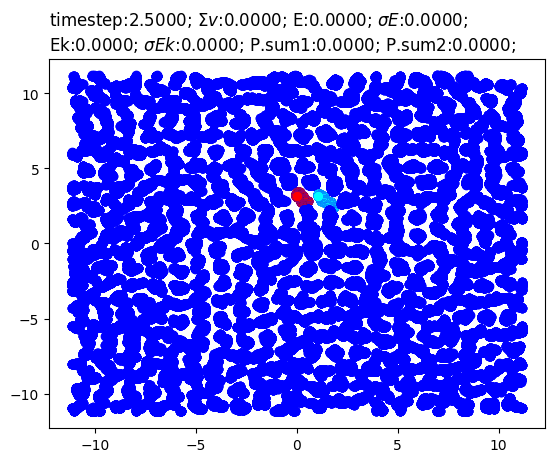

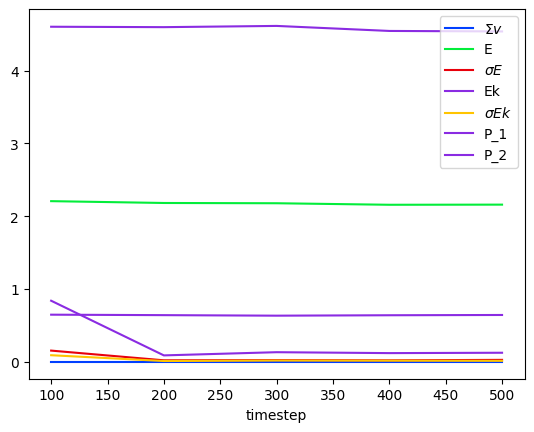

In [11]:
# 2D SOFT-DISK SIMULATION: THE MAIN LOOP

# Import libraries for system operations
import os.path
from os import path
import shutil

# PARAMETERS
mov = 1 # set mov=1 if you want make a video

# Set a working directory for all the png and videos
workdir = str(os.getcwd()+'/')

# If the /coo directory doesn't exist make it, else remove /coo (and its contents) and 
# create a new /coo directory.
if path.exists(str(workdir+'coo'))==False:
    os.makedirs(str(workdir+'coo'))
else:
    shutil.rmtree(str(workdir+'coo'))
    os.makedirs(str(workdir+'coo'))

# Load the input parameter file
df_params = pd.read_csv('Rap_2_LJP.in', sep='\t', header=None, names=['parameter', 'value'])

NDIM = 2 # Two-Dimension setting
vSum = np.asarray([0.0, 0.0]) # velocity sum
kinEnergy =Prop(0.0, 0.0, 0.0) #Ek (and average)
totEnergy =Prop(0.0, 0.0, 0.0) #E (and average)
pressure  =Prop(0.0, 0.0, 0.0) #P (and average) 

systemParams = []

IADD = 453806245
IMUL = 314159269
MASK = 2147483647
SCALE = 0.4656612873e-9
randSeedP = 17

deltaT = float(df_params.values[0][1])
density = float(df_params.values[1][1])

initUcell = np.asarray([0.0, 0.0]) # initialize cell
initUcell[0] = int(df_params.values[2][1])
initUcell[1] = int(df_params.values[3][1])

stepAvg = int(df_params.values[4][1])
stepEquil = float(df_params.values[5][1])
stepLimit = float(df_params.values[6][1])
temperature = float(df_params.values[7][1])
float(df_params.values[7][1])

#Define an array of Mol
mol = [Mol(np.asarray([0.0, 0.0]), \
           np.asarray([0.0, 0.0]), \
           np.asarray([0.0, 0.0])) for i in range(int(initUcell[0]*initUcell[1]))]


# Define the number of molecules
global nMol
nMol = len(mol)

# LJP parameters:
epsilon =  1
sigma = 1


# START THE MAIN LOOP
SetParams()
SetupJob()
moreCycles = 1

n = 0
while moreCycles:
    SingleStep()
    if mov==1:
        plotMolCoo(mol, workdir, n) # Make a graph of the coordinates
    n += 1
    if stepCount >= stepLimit:
        moreCycles = 0
        

columns = ['timestep','timeNow', '$\Sigma v$', 'E', '$\sigma E$', 'Ek', '$\sigma Ek$', 'P_1', 'P_2']
df_systemParams = pd.DataFrame(systemParams, columns=columns)        

# Make a video
if mov==1:
    makeMov()

GraphOutput()

